# Numerische Simulation einer (gekoppelten) Seilwelle

In diesem interaktiven Python Skript innerhalb Jupyter Notebook wird die Bewegung eines Seils, welches durch gekoppelte Federn genähert wird, numerisch mit dem Euler-Einschritt-Verfahren simuliert und anschließend in einer Animation visualisiert.

Dazu müssen analog zu der Simulation in einem Numbers oder Excel Skript verschiedene $\textit{Formeln}$, wie zum Beispiel die der Beschleunigung, programmiert werden. Auch hier müssen zu Beginn erst einmal einige Variablen (Konstanten) angegeben werden. Während in Numbers oder Excel in einer Tabelle alle Berechnungen einer einzelnen Masse standen, werden die Berechnungen hier alle nacheinander aber immer $\textbf{für alle Massen gleichzeitig}$ durchgeführt. Aus diesem Grund können hier auch im Prinzip beliebig viele Massen simuliert werden, wohingegen in Numbers oder Excel für jede Masse mit viel Aufwand eine weitere Tabelle angelegt werden muss. 

In diesem Skript wird die Programmiersprache Python verwendet und es werden viele verschiedene $\textit{Tools}$ und $\textit{Features}$ verwendet, die du nicht verstehen wirst und auch $\textbf{nicht verstehen musst}$. Du findest vor jedem Abschnitt eine kurze Erläuterung, um ungefähr zu verstehen, was in dem Block passiert (warum und wie das funktioniert, brauchst du aber nicht zu wissen).

Um die entscheidenden Schritte aus dem Numbers oder Excel Skript hier wieder zu finden, gibt es eine PDF, die dir die entsprechenden Stellen markiert.

## Anleitung

$\textbf{In Python wird jede Zeile (hier jeder Block) Schritt für Schritt ausgeführt. Fange also zu Beginn ganz oben an.}$

<blockquote>
1. Klicke auf den obersten Block des Skripts (links stehen leere eckige Klammern).
<br>
<br>    
2. Drücke $\textbf{shift + Enter}$  
<br> 
$\Rightarrow$ In den eckigen Klammern (links) sollte jetzt eine Nummer erscheinen. Der Cursor geht automatisch einen Block weiter.
<br>
<br> 3. Wiederhole Schritt 2 für jeden weiteren Block. Achte darauf, dass bei dem Block zuvor eine Nummer erschienen ist, bevor du weiter machst (an einigen Stellen dauert es etwas länger, solange steht dort ein [*]).
<br>
<br> 4. Sobald du im Code (graue Box) $\textbf{etwas geändert}$ hast (z.B. die Größen der Konstanten etc.) musst du $\textbf{alle folgenden grauen Blöcke erneut ausführen}$ (siehe in der Anleitung Schritt 1, statt dem obersten Block, beginnst du mit dem veränderten Block). Wenn du das nicht machst, weiß das Programm nichts von den geänderten Einstellungen der Slider :) $\textit{(Tipp: Du kannst immer an den Nummern erkennen, wie aktuell die jeweilige graue Box gerade ist)}$
</blockquote>

$\textbf{ Sollte irgendetwas nicht mehr funktionieren (zum Beispiel erscheinen links einfach keine Nummern) dann gehe wie folgt vor:}$
<blockquote>
A. Klicke ganz oben auf Kernel und dann auf Restart.
<br> 
<br> 
B. Beginne bei der Anleitung ab Schritt 1.
<br>
<br>
$\scriptsize{\textbf{Manchmal musst du vor dem Restart auf Shutdown klicken.}}$
</blockquote>


# Ab hier fängt das Skript an. Viel Spaß!

# Vorbereitungen

## Pakete etc. laden

Hier werden einige $\textit{Tools}$ und $\textit{Feautures}$ geladen.

In [1]:
# Für Plots und Animationen%matplotlib notebook
import matplotlib 
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.animation import ImageMagickWriter, FFMpegWriter #PillowWriter, HTMLWriter
import animatplot as amp
import progressbar

# Für Berechnungen
import numpy as np

# Für kompilierten Code (bessere Performance!)
from numba import jit

In [2]:
# Eigene Funktionen für die Startwerte
from startwave import start_triangle, start_pulse

## Verschiedene Konstanten definieren

- physikalische Konstanten (Federkopplung, Masse, Länge des Seils, Anzahl der Massen usw.)
- numerische Konstanten (Zeitschrittweite dt, Gesamtzeit)
- Konstanten für die Visualisierung (z.B. Zu welchen Zeiten wird die Seilwelle dargestellt)

In [70]:
''' Konstanten '''

'''physikalische Konstanten'''
k = 1
K = 0.01 
m = 1

'''numerische Konstanten'''
dx = 0.01
L = 10
N = int(L/dx)

dt = 0.05
# Zahl der Zeitschritte
NT = 10000
# Gesamtzeit
T = (NT+1)*dt

'''Konstanten für die Visualisierung'''
tsave = 100
number_of_frames = int(NT/tsave)

# Numerik

## Berechnung der Beschleunigung programmieren

- $F = k \cdot \left(s(x+\Delta x)-2\cdot s(x)+s(x-\Delta x)\right) - K \cdot s(x)$
- $a = \frac{F}{m} = \frac{k}{m} \cdot \left(s(x+\Delta x)-2\cdot s(x)+s(x-\Delta x)\right) - \frac{K}{m} \cdot s(x)$
- $k$ ist die Kopplung zwischen den Massen
- $K$ ist die Kopplung der Masse nach außen

In [71]:
''' Beschleunigungsfunktion '''

@jit(nopython=True)
def a(s):
    s_plus = np.roll(s,1)
    s_minus = np.roll(s,-1)
    return k/m * (s_plus - 2*s + s_minus) - K/m * s

## Das Eulersche Einschrittverfahren programmieren

- s_start, v_start: Startwerte für die Strecke und Geschwindigkeit angeben
- s_plot, v_plot: Möglichkeit zum Speichern einiger Werte für das Visualisieren später angeben
- Schließlich Zeitschritt für Zeitschritt berechnen (und zwischendurch die Werte speichern)
- Zeitschritt für Zeitschritt wird die Berechnung der Geschwindigkeit v und Strecke s durchgeführt (insgesamt NT mal):
    - $a$ mit der Beschleunigungsfunktion von oben berechnet
    - $v_{neu} = a \cdot \Delta t + v_{alt}$
    - $s_{neu} = v \cdot \Delta t + s_{alt}$
- (Für diejenigen mit etwas Programmiererfahrung: @jit sorgt dafür, dass der Python Code in der Funktion compiliert wird und die Berechnung dadurch deutlich schneller wird.)

In [72]:
'''Simulation'''

# Alles was zu der Simulation gehört wird in eine sogenannte Funktion gepackt, die wir simulation() nennen.
# Die Ergebnisse der Funktion stehen hinter dem Wort return ganz am Ende. 

@jit(nopython=True)
def simulation():

    ''' Startwerte '''
    s_start = np.zeros(N, dtype=np.float64)
    v_start = np.zeros(N, dtype=np.float64)
    
    # Anfangsbedingung: Nach rechts wandernder Wellenberg
    s_start, v_start = start_pulse(N, m, K, 200)
    # Alternative Anfangsbedingung: Dreieckauslenkung, ohne Anfangsgeschwindigkeit 
    #s_start, v_start = start_triangle(N)

    ''' Werte (s, v) die in jedem Schritt neu berechnet werden. Zu Beginn entsprechen sie den Startwerten. '''
    
    s = s_start
    v = v_start

    ''' Daten für das Plotten '''
    
    # nicht jeder berechnete Wert soll geplottet werden, das wird sonst viel zu viel
    splot = np.zeros((number_of_frames+1, N))
    vplot = np.zeros((number_of_frames+1, N))
    # Startwerte sollen auch geplottet werden
    splot[0] = s_start
    vplot[0] = v_start

    ''' Zeitschritt für Zeitschritt 
    
    wird die Geschwindigkeit aus der Beschleunigung
    und die Strecke aus der Geschwindigkeit berechnet '''

    # Das ist eine Schleife, dass bedeutet, dass der Vorgang NT-mal wiederholt wird.  
    for t in range(1, NT+1):
        v = a(s) * dt + v
        s = v * dt + s

        # % steht für modulo: Immer nach tsave Zeitschritten, 
        # wird der Wert für die Strecke und die Geschwindigkeit gespeichert.
        if t % tsave == 0:
            splot[int(t/tsave)] = s
            vplot[int(t/tsave)] = v
    
    # Das sind die Ergebnisse (für alle gespeicherten Zeitwerte finden sich in splot und vplot 
    # die entsprechenden Werte für die Strecke und Geschwindigkeit)
    return splot, vplot

In [73]:
# Nun führen wir alles was in der Funktion simulation() steht aus.
# Die Ergebnisse speichern wir ab unter sdata und vdata.

sdata, vdata = simulation()

Du willst wissen wie die Startwerte für die Auslenkung und Geschwindigkeit aussehen? Dann kommentiere alle Zeilen im folgenden Block wieder ein ('#' entfernen) und lasse sie dir dadurch plotten. Ansonsten kannst du auch mit dem übernächsten Block fortfahren.

<IPython.core.display.Javascript object>


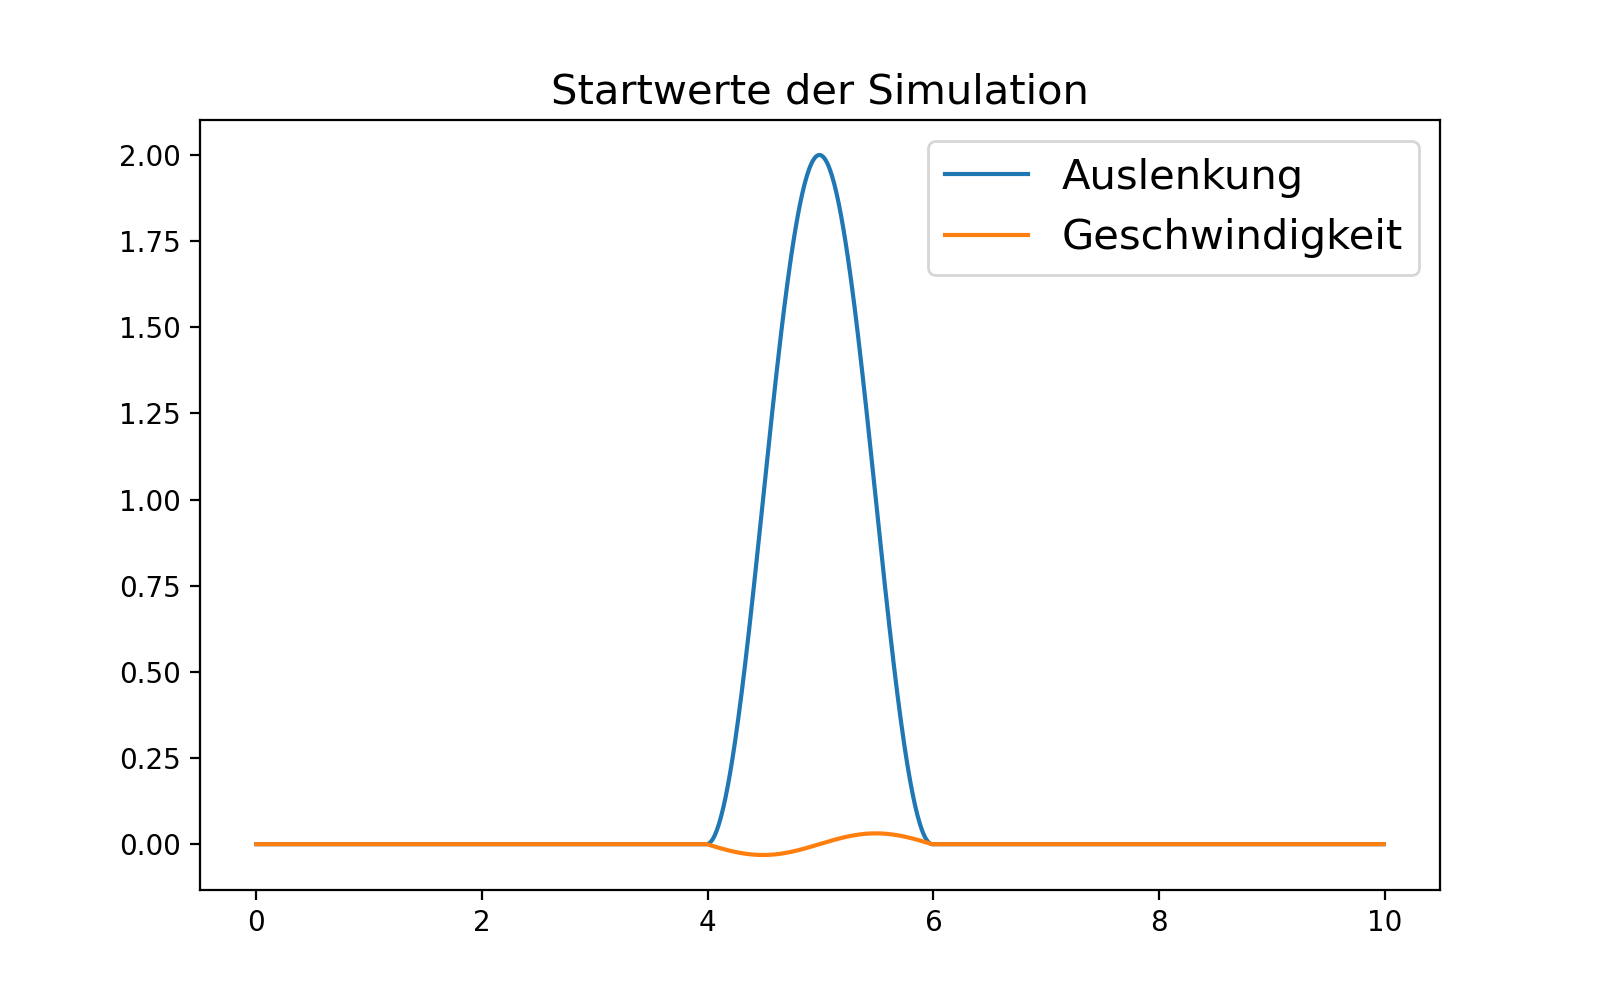

In [74]:
fig2 = plt.figure(figsize=(8, 5))
plt.plot(np.arange(0, L, dx), sdata[0], label='Auslenkung')
plt.plot(np.arange(0, L, dx), vdata[0], label='Geschwindigkeit')
plt.legend(fontsize=15)
plt.title('Startwerte der Simulation', fontsize=15)
plt.show()

Die Gesamtenergie $E_{ges}$ einer Masse setzt sich aus ihrer kinetischen Energie $E_{kin}$ und den potentiellen Energien $E_{pot}$ der Federn zusammen. Dabei werden die Federn zu den Nachbarmassen nur jeweils zur Hälfte dazugerechnet.

- $E_{kin} = \frac{1}{2} \cdot m \cdot v(x)^2$
- $E_{pot} = \frac{1}{2} \cdot K \cdot s(x)^2$
- $E_{pot, \leftarrow} = \frac{1}{2} \cdot \frac{1}{2} \cdot k \cdot (s(x) - s(x-\Delta x))^2\;\;,$ $\;\;E_{pot, \rightarrow} = \frac{1}{2} \cdot \frac{1}{2} \cdot k \cdot (s(x) -s(x+\Delta x))^2$
- $E_{ges} = E_{kin} + E_{pot, \leftarrow} + E_{pot, \rightarrow} + E_{pot}$

In [76]:
# Wir können auch die Gesamtenergie jeder Masse plotten.
# Dazu wird die kinetische und potentielle Energie jeweils zusammengerechnet.

E_kin = 0.5 * m * vdata**2
E_pot_links = 0.5 * 0.5 * k * (sdata - np.roll(sdata, 1, axis=1)) **2
E_pot_rechts = 0.5 * 0.5 * k * (sdata - np.roll(sdata, -1, axis=1)) **2
E_pot = 0.5* K * sdata **2
E_total = E_kin + E_pot_links + E_pot_rechts + E_pot

# Zur besseren Darstellung wird die Gesamtenergie durch die maximale Energie geteilt, 
# sodass die Werte nur zwischen 0 und 1 liegen.

E_max = np.max(E_total)
E_normal = (E_total)/E_max

Du willst wissen wie die Startwerte für die Energien aussehen? Dann kommentiere alle Zeilen im folgenden Block wieder ein ('#' entfernen) und lasse sie dir dadurch plotten. Ansonsten kannst du auch mit dem übernächsten Block fortfahren.

<IPython.core.display.Javascript object>


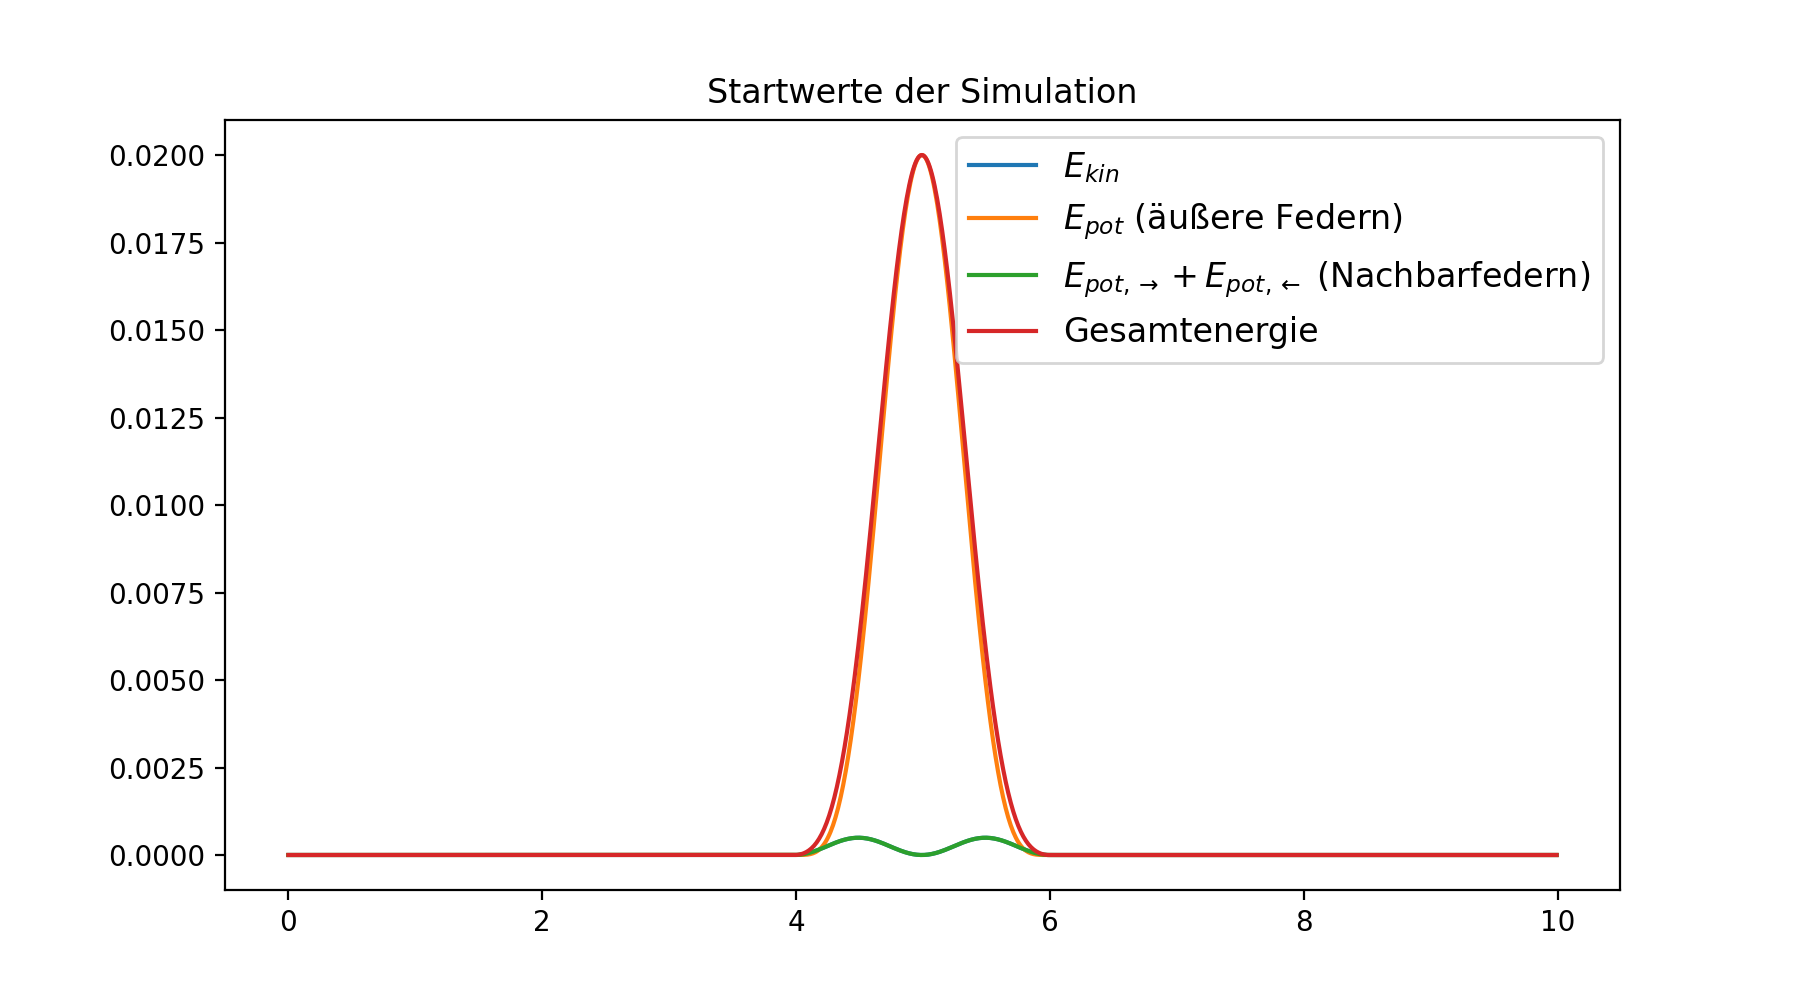

In [77]:
fig3 = plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, L, dx), E_kin[0], label='$E_{kin}$')
plt.plot(np.arange(0, L, dx), E_pot[0], label='$E_{pot}$ (äußere Federn)')
plt.plot(np.arange(0, L, dx), E_pot_links[0]+E_pot_rechts[0], label=r'$E_{pot, \rightarrow}+ E_{pot, \leftarrow}$ (Nachbarfedern)')
plt.plot(np.arange(0, L, dx), E_total[0], label='Gesamtenergie')
plt.legend(fontsize=12)
plt.title('Startwerte der Simulation', fontsize=12)
plt.show()

# Animation der Seilwelle

## Animation programmieren und starten

- Das Layout des Diagramms (Achsen, Größe, etc.) programmieren
- Angeben welche Daten dargestellt werden sollen (y-Achse, x-Achse und die Zeit)
- Zusätzlich die Möglichkeit einbauen, dass manuel die Zeit mit einem Slider verstellt werden kann

##### Gib an welche Daten geplottet werden sollen (Auslenkung oder Energie):
Kommentiere die andere Zeile mit # aus. Vergiss das entsprechende label nicht!

In [78]:
data = E_normal 
label = 'Energie (normiert) E'
#data = sdata
#label = 'Auslenkung s'

$\textbf{Alles was in dem folgendem Code Block steht ist kompliziert und muss nicht verstanden werden!}$ 
    
$\textbf{Einfach ausführen (shift + Enter) und staunen was passiert.}$

In [79]:
from tkinter import Tk
from tkinter import filedialog as fd
from ipywidgets import widgets
import matplotlib as mpl
mpl.rcParams['toolbar'] = 'None'

In [80]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

<IPython.core.display.Javascript object>


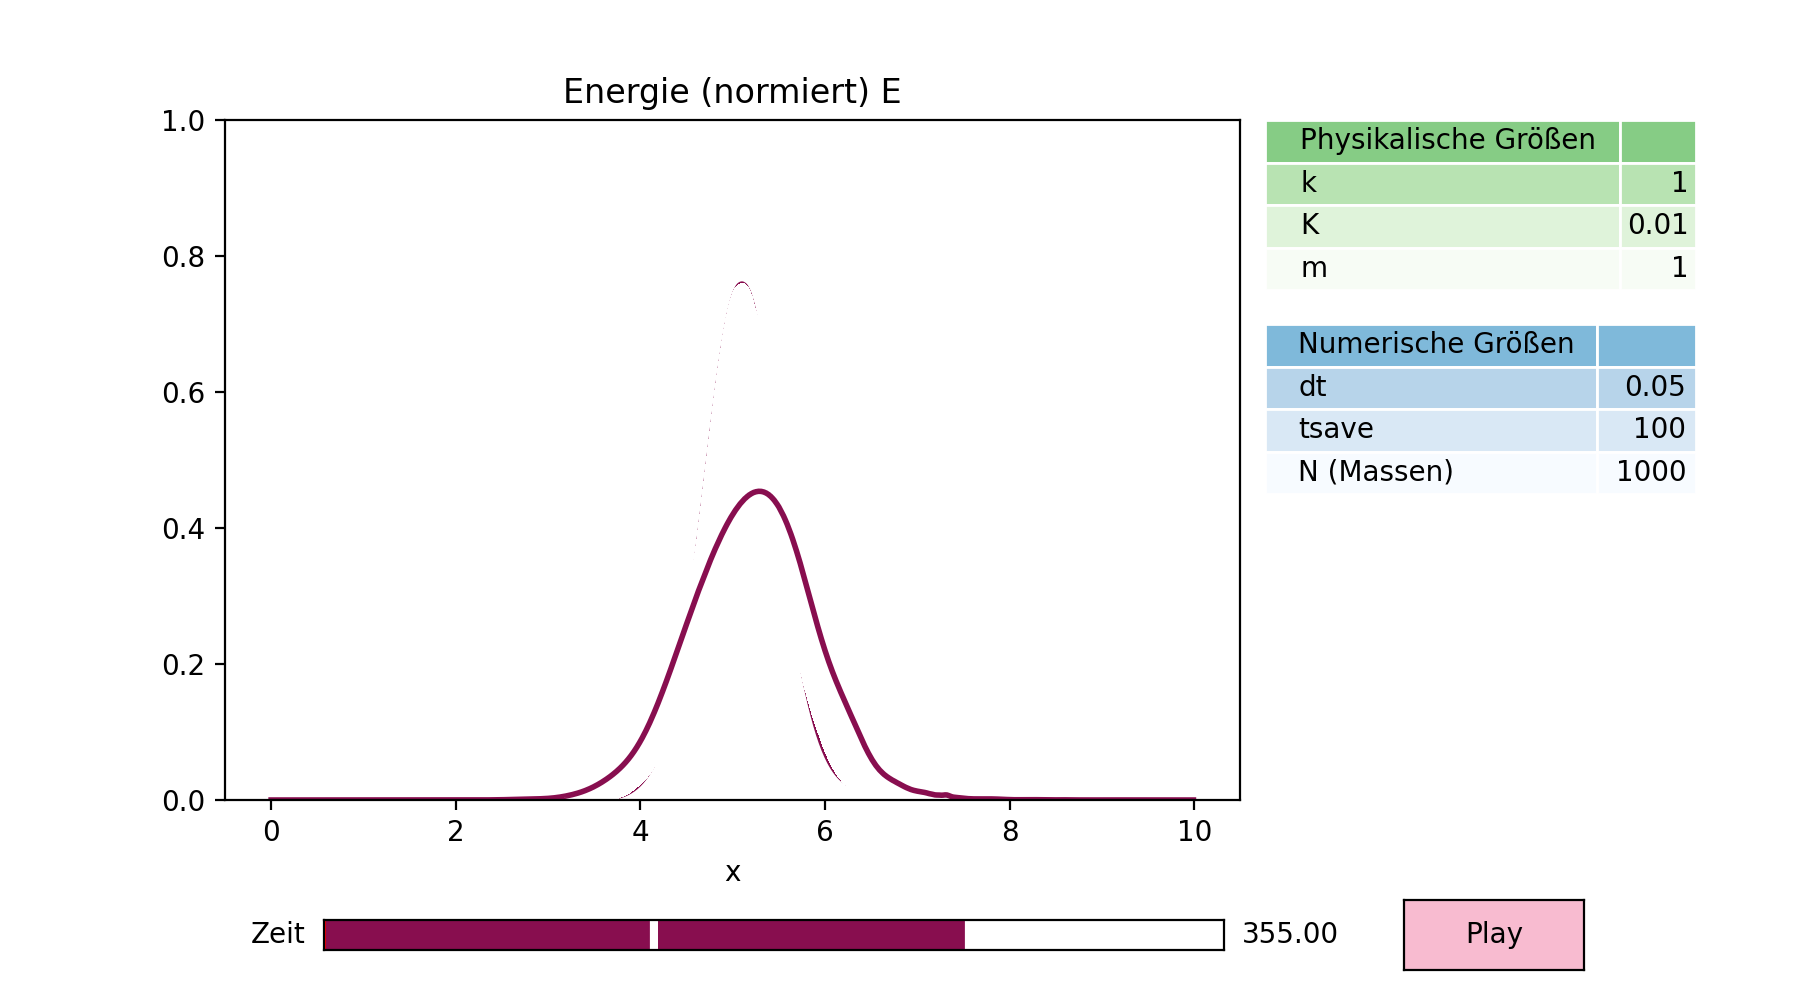

Button(description='Bild speichern', style=ButtonStyle())

In [81]:
from colortheme import colortheme
fc, lc, pc, bhc, bc, rc1, rc2 = colortheme('light')
matplotlib.rcParams["figure.facecolor"] = fc

''' Layout des Plots gestalten'''

x = np.arange(0, L, dx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5), gridspec_kw={'width_ratios': [4, 1]}, facecolor=fc)

ax1.set_xlabel('x', color=lc)
ax1.set_title(label, color=lc)
ax1.set_ylim([np.min(data),np.max(data)])

# Farbschema des Graphen anpassen
for child in ax1.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color(lc)
ax1.tick_params(colors=lc)
ax1.set_facecolor(fc)

# Tabellen rechts neben dem Graphen erstellen und Farbschema anpassen
ax2.axis('off')
tab1 = ax2.table(cellText=[['Werte'], [k], [K], [m]], 
                rowLabels=['Physikalische Größen','k', 'K', 'm'],
                cellLoc='right',
                cellColours=[[col] for col in rc2],
                rowColours=rc2,
                colWidths=[0.6, 0.3],
                bbox=[1.0, 0.75, 0.4, 0.25])

tab2 = ax2.table(cellText=[['Werte'],[dt], [tsave], [N]],
          rowLabels=['Numerische Größen', 'dt', 'tsave', 'N (Massen)'],
          cellLoc='right',
          colWidths=[0.6, 0.2],
          cellColours=[[col] for col in rc1],
          rowColours=rc1,
          bbox=[0.91, 0.45,0.49, 0.25])

for c in tab1.get_celld().values():
    c.set_edgecolor(fc)
    c.get_text().set_color(lc)
    
for d in tab2.get_celld().values():
    d.set_edgecolor(fc)
    d.get_text().set_color(lc)
    
tab1.auto_set_font_size(False)
tab1.set_fontsize(10)
tab2.auto_set_font_size(False)
tab2.set_fontsize(10)

''' Daten für die Animation '''

t = np.arange(0, T+dt, dt*tsave)
X, time = np.meshgrid(x, t)
block = amp.blocks.Line(X, data, ax=ax1, color=pc, lw=2)

''' Time Slider hinzufügen'''

timeline = amp.Timeline(time, fps=15)

''' Animation konfigurieren und starten '''
anim = amp.Animation([block], timeline)
anim.controls({'text':'Zeit', 'color':pc})

# Farbschema anpassen
anim.slider.valtext.set_color(lc)
anim.slider.label.set_color(lc)
anim.button.hovercolor = bhc
anim.button.color = bc
anim.button.label.set_color(lc)
anim.button.label2.set_color(lc)

button = widgets.Button(description="Bild speichern")
display(button)

def save_figure(b):
    Tk().withdraw() # create and withdraw root window
    save_name = fd.asksaveasfilename(defaultextension='pdf')
    if save_name:
        
        fig.savefig(save_name, facecolor=fig.get_facecolor(), edgecolor='none')
        
button.on_click(save_figure)

plt.show()

## Animation speichern

Hier kannst du das obige Video abspeichern. In dem ersten Block kannst du den Namen ändern, wenn du möchtest. Beachte dabei folgendes:
- Der Name muss zwischen zwei Anführungsstrichen stehen
- Der Name darf keine Sonderzeichen oder Leerzeichen enthalten
- Der Name muss mit .mp4 enden

In [ ]:
videoname = 'seilwelledelme.mp4'

Im nächsten Block wird das Video gespeichert. Darunter findest du dann einen Ladebalken. Warte ab, bis das Video vollständig gespeichert wurde, bevor du es öffnest oder neue Simulationen startest.

In [ ]:
# Slider zurücksetzen
anim.slider.set_val(0)


print('Saving ...')

# Überprüfe welcher Writer verwendet werden kann
if FFMpegWriter.isAvailable():
    writer = 'ffmpeg'
elif ImageMagickWriter.isAvailable():
    writer = 'imagemagick'
elif PillowWriter.isAvailable():
    writer = 'pillow'
else:
    writer = None
    raise RuntimeError('Cannot find any Writer for saving video. Download one of the following writers: ffmpeg, imagemagick or pillow.')



bar = progressbar.ProgressBar(max_value=number_of_frames)
bar.start()

def progress(current_frame, total_frames):
    bar.update(current_frame)


anim.save(videoname, writer=writer, progress_callback = lambda i, n: progress(i,n), fps=15, savefig_kwargs={'facecolor':fig.get_facecolor()})
bar.finish()

#### Hier endet das Skript! 